In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import lfilter,correlate
import tensorflow.keras.layers as tfl
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau

2024-06-15 19:37:47.442211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 19:37:47.442319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 19:37:47.552666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def pre_emphasis(signal,factor=0.97):
    return np.append(signal[0], signal[1:] - factor * signal[:-1])

In [3]:
def inverse_filtering(signal, lpc_coeffs):
    return lfilter(np.concatenate(([1], -lpc_coeffs[1:])), [1], signal)

In [4]:
def compute_lpc(signal, order):
    autocorr = correlate(signal, signal, mode='full')
    autocorr = autocorr[len(signal)-1:len(signal)+order]
    
    a = np.concatenate(([1], -autocorr[1:order+1]))
    b = [1]
    
    lpc_coeffs = lfilter(b, a, signal)
    
    lpc_coeffs = np.concatenate(([1], -lpc_coeffs[1:order+1]))
    
    del autocorr,a,b
    
    return lpc_coeffs

In [5]:
def lpc_to_cepstrum(lpc_coeffs):
    return np.fft.ifft(np.log(np.abs(np.fft.fft(lpc_coeffs))))

In [6]:
import gc
from IPython.display import clear_output

def create_spectrograms(train_folder, create_folder, verbose=False, speakers=50, utterances=10, sr=44100, frame_length=2048, hop_length=512, lpc_order=16):
    spc_folder = os.path.join(create_folder, "spectrogram")
    vt_folder = os.path.join(create_folder, "vocal_tract")
    glot_folder = os.path.join(create_folder, "glottal")
    
    total_speaker = 0
    for speaker in os.listdir(train_folder):
        total_utterances = 0
        speaker_folder_spc = os.path.join(spc_folder, speaker)
        speaker_folder_vt = os.path.join(vt_folder, speaker)
        speaker_folder_glot = os.path.join(glot_folder, speaker)
        os.makedirs(speaker_folder_spc, exist_ok=True)
        os.makedirs(speaker_folder_vt, exist_ok=True)
        os.makedirs(speaker_folder_glot, exist_ok=True)
        
        for vidID in os.listdir(os.path.join(train_folder, speaker)):
            for file in os.listdir(os.path.join(train_folder, speaker, vidID)):
                if file.endswith(".wav"):
                    wav_file_path = os.path.join(train_folder, speaker, vidID, file)
                    
                    y, sr = librosa.load(wav_file_path, sr=sr)
                    
                    y_preemphasized=pre_emphasis(y)
                    
                    frames = librosa.util.frame(y_preemphasized, frame_length=frame_length, hop_length=hop_length).T
                    del y_preemphasized
                    
                    window = np.hamming(frame_length)
                    frames_windowed = frames * window  
                    del frames
                    
                    lpc_coeffs = []
                    for frame in frames_windowed:
                        frame=np.array(frame)
                        coeff = compute_lpc(frame, lpc_order)
                        lpc_coeffs.append(coeff)
                        
                    glottal_waveforms = [inverse_filtering(frame, coeff) for frame, coeff in zip(frames_windowed, lpc_coeffs)]

                    residuals = []
                    for i, coeff in enumerate(lpc_coeffs):
                        frame = frames_windowed[i]
                        residual = lfilter(coeff, [1.0], frame)
                        residuals.append(residual)
                        
                    residual_avg = np.mean(np.abs(np.array(residuals)), axis=0)
                    
                    del frames_windowed, lpc_coeffs, residuals
                    gc.collect()

                    try:
                        plt.figure(figsize=(5, 5))
                        ax = plt.axes()
                        ax.set_axis_off()
                        plt.set_cmap('hot')
                        amp=np.abs(librosa.stft(y))
                        D = librosa.amplitude_to_db(amp, ref=np.max)
                        del y,amp
                        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
                        output_path = os.path.join(speaker_folder_spc, "spc"+str(total_utterances+1) + ".png")
                        plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
                        plt.close('all')
                        del D,ax,output_path
                        gc.collect()

                        plt.figure(figsize=(5, 5))
                        ax = plt.axes()
                        ax.set_axis_off()
                        plt.set_cmap('hot')
                        amp=np.abs(librosa.stft(residual_avg))
                        D_residual = librosa.amplitude_to_db(amp, ref=np.max)
                        del amp
                        librosa.display.specshow(D_residual, sr=sr, x_axis='time', y_axis='log')
                        output_path = os.path.join(speaker_folder_vt, "vt"+str(total_utterances+1) + ".png")
                        plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
                        plt.close('all')
                        del D_residual,ax,output_path
                        gc.collect()

                        plt.figure(figsize=(5, 5))
                        ax = plt.axes()
                        ax.set_axis_off()
                        plt.set_cmap('hot')
                        amp=np.abs(librosa.stft(glottal_waveforms[0]))
                        D_glot = librosa.amplitude_to_db(amp, ref=np.max)
                        del amp
                        librosa.display.specshow(D_glot, sr=sr, x_axis='time', y_axis='log')
                        output_path = os.path.join(speaker_folder_glot, "glot"+str(total_utterances+1) + ".png")
                        plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
                        plt.close('all')
                        del D_glot,ax,output_path
                        gc.collect()
                        
#                         clear_output()
                    
                    except OSError as e:
                        print(f"Error saving spectrogram for {wav_file_path}: {e}")
                    
                    del glottal_waveforms, residual_avg
                    gc.collect()
    
                    total_utterances += 1
                    if total_utterances == utterances:
                        break
            
            if total_utterances == utterances:
                break
        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")
        
        if total_speaker == speakers:
            break

In [3]:
raw_dataset_loc="/kaggle/input/voxceleb1train/wav"
save_loc="/kaggle/working/"
num_speakers=5
num_utterances=100

In [7]:
create_spectrograms(raw_dataset_loc,save_loc,True,num_speakers,num_utterances)

5 speakers completed.



In [8]:
del plt,librosa

In [42]:
from PIL import Image

dataset_path_spc="/kaggle/working/spectrogram"
dataset_path_vt="/kaggle/working/vocal_tract"
dataset_path_glot="/kaggle/working/glottal"
folders=os.listdir(dataset_path_spc)

# Initializing training and test dataset
X_train=[[],[],[]]
y_train=[[],[],[]]
X_test=[[],[],[]]
y_test=[[],[],[]]

# Split the dataset into training and test set.
num=np.random.rand(num_utterances*num_speakers)
mask=num<0.2
split=mask.astype(int)

for dirs in folders:
    i=0
    for img in os.listdir(os.path.join(dataset_path_spc,dirs)):
        image=Image.open(os.path.join(dataset_path_spc,dirs,img))
        new_img=image.resize((200,200))
        tmp_array=np.array(new_img)/255.
        if split[i]==0:
            X_train[0].append(tmp_array)
            y_train[0].append(str(dirs))
        else:
            X_test[0].append(tmp_array)
            y_test[0].append(str(dirs))
            
        i+=1
        
    i=0    
    for img in os.listdir(os.path.join(dataset_path_vt,dirs)):
        image=Image.open(os.path.join(dataset_path_vt,dirs,img))
        new_img=image.resize((200,200))
        tmp_array=np.array(new_img)/255.
        if split[i]==0:
            X_train[1].append(tmp_array)
            y_train[1].append(str(dirs))
        else:
            X_test[1].append(tmp_array)
            y_test[1].append(str(dirs))
            
        i+=1
            
    i=0
    for img in os.listdir(os.path.join(dataset_path_glot,dirs)):
        image=Image.open(os.path.join(dataset_path_glot,dirs,img))
        new_img=image.resize((200,200))
        tmp_array=np.array(new_img)/255.
        if split[i]==0:
            X_train[2].append(tmp_array)
            y_train[2].append(str(dirs))
        else:
            X_test[2].append(tmp_array)
            y_test[2].append(str(dirs))
        
        i+=1

In [44]:
dict={}
i=0
for val in folders:
    dict[val]=i
    i=i+1

dict

{'id11123': 0, 'id10116': 1, 'id10484': 2, 'id11079': 3, 'id10459': 4}

In [45]:
i=0
for _ in y_train[0]:
    y_train[0][i]=dict[y_train[0][i]]
    i=i+1

i=0
for _ in y_test[0]:
    y_test[0][i]=dict[y_test[0][i]]
    i=i+1
    
i=0
for _ in y_train[1]:
    y_train[1][i]=dict[y_train[1][i]]
    i=i+1

i=0
for _ in y_test[1]:
    y_test[1][i]=dict[y_test[1][i]]
    i=i+1
    
i=0
for _ in y_train[2]:
    y_train[2][i]=dict[y_train[2][i]]
    i=i+1

i=0
for _ in y_test[2]:
    y_test[2][i]=dict[y_test[2][i]]
    i=i+1

In [46]:
def convolutional_model(input_shape,output_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1=tfl.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(input_img)
    A1=tfl.ReLU()(Z1)
    P1=tfl.MaxPool2D(pool_size=(4,4),padding='same')(A1)
    Z2=tfl.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),padding='same')(P1)
    A2=tfl.ReLU()(Z2)
    P2=tfl.MaxPool2D(pool_size=(4,4),padding='same')(A2)
    Z3=tfl.Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),padding='same')(P2)
    A3=tfl.ReLU()(Z3)
    P3=tfl.MaxPool2D(pool_size=(4,4),padding='same')(A3)
    F=tfl.Flatten()(P3)
    D1=tfl.Dense(128)(F)
    DP1=tfl.Dropout(0.5)(D1)
    
    outputs=tfl.Dense(output_shape,activation='softmax')(DP1)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [47]:
conv_model_spc = convolutional_model((200, 200, 4),num_speakers)
conv_model_spc.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [48]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0], y_train[0])).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test[0], y_test[0])).batch(16)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

# history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))
history = conv_model_spc.fit(np.array(X_train[0]),np.array(y_train[0]), batch_size=32, epochs=100, validation_data=(np.array(X_test[0]),np.array(y_test[0])),callbacks=(reduce_lr))

Epoch 1/100
 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1491 - loss: 1.7492

W0000 00:00:1718481310.889617    2254 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.1688 - loss: 1.7237

W0000 00:00:1718481313.164514    2254 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.1721 - loss: 1.7193 - val_accuracy: 0.2500 - val_loss: 1.5683 - learning_rate: 0.0010
Epoch 2/100
 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4062 - loss: 1.5000

W0000 00:00:1718481313.852497    2257 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3890 - loss: 1.5197 - val_accuracy: 0.4688 - val_loss: 1.4968 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4601 - loss: 1.4488 - val_accuracy: 0.3281 - val_loss: 1.3918 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4125 - loss: 1.3391 - val_accuracy: 0.4375 - val_loss: 1.2251 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6086 - loss: 1.1035 - val_accuracy: 0.5781 - val_loss: 1.0958 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5925 - loss: 1.0723 - val_accuracy: 0.5469 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5940 - loss: 1.0929 - val_accuracy: 0.6875 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6463 - loss: 0.9450 - val_accuracy

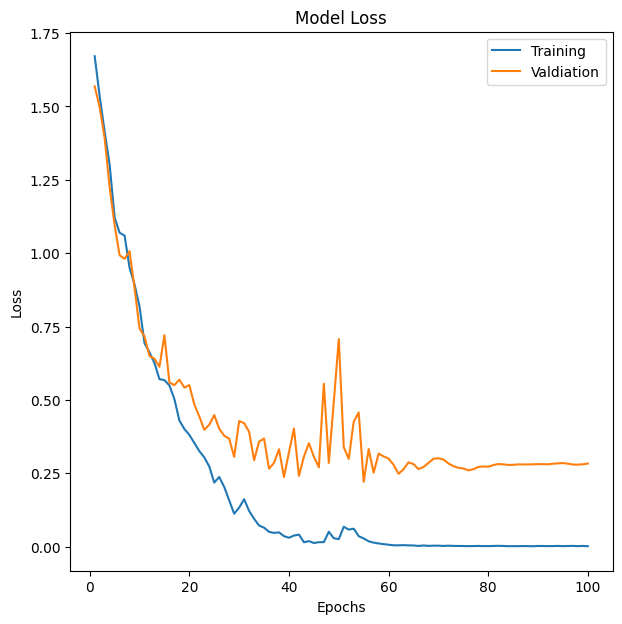

In [50]:
plt.figure(figsize=(7,7))
model_loss = history.history['loss']
model_val_loss = history.history['val_loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_loss)+1), model_val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.close()

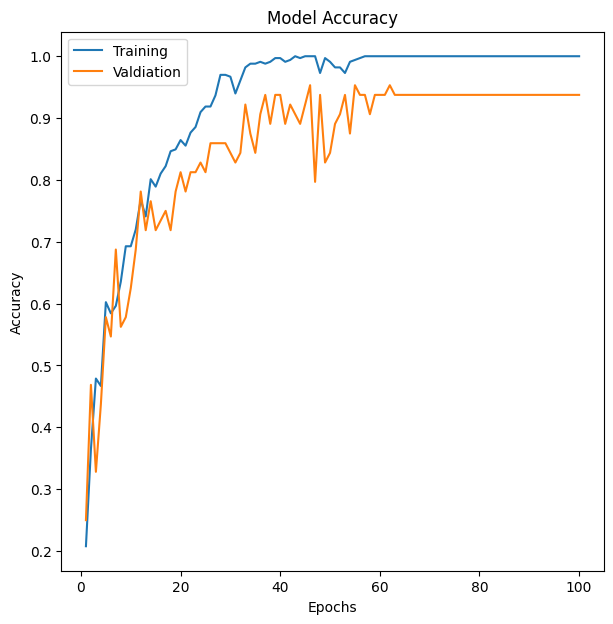

In [51]:
plt.figure(figsize=(7,7))
model_acc = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_acc)
plt.plot(range(1,len(model_loss)+1), model_val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.close()

In [52]:
conv_model_glot = convolutional_model((200, 200, 4),num_speakers)
conv_model_glot.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [53]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0], y_train[0])).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test[0], y_test[0])).batch(16)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

# history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))
history_glot = conv_model_glot.fit(np.array(X_train[2]),np.array(y_train[2]), batch_size=32, epochs=100, validation_data=(np.array(X_test[2]),np.array(y_test[2])),callbacks=(reduce_lr))

Epoch 1/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1896 - loss: 1.7354

W0000 00:00:1718481533.478764    2256 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1967 - loss: 1.7117

W0000 00:00:1718481535.798854    2255 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.1986 - loss: 1.7059 - val_accuracy: 0.4062 - val_loss: 1.5262 - learning_rate: 0.0010
Epoch 2/100
 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4112 - loss: 1.5084

W0000 00:00:1718481536.326667    2257 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3618 - loss: 1.5271 - val_accuracy: 0.4219 - val_loss: 1.4830 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3715 - loss: 1.4947 - val_accuracy: 0.4219 - val_loss: 1.3955 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4083 - loss: 1.4228 - val_accuracy: 0.3906 - val_loss: 1.3328 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3891 - loss: 1.4088 - val_accuracy: 0.4062 - val_loss: 1.3118 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4512 - loss: 1.3863 - val_accuracy: 0.4531 - val_loss: 1.3221 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3793 - loss: 1.4176 - val_accuracy: 0.4688 - val_loss: 1.2716 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4429 - loss: 1.3294 - val_accuracy

In [54]:
conv_model_vt = convolutional_model((200, 200, 4),num_speakers)
conv_model_vt.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [55]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0], y_train[0])).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test[0], y_test[0])).batch(16)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

# history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))
history_vt = conv_model_vt.fit(np.array(X_train[1]),np.array(y_train[1]), batch_size=32, epochs=100, validation_data=(np.array(X_test[1]),np.array(y_test[1])),callbacks=(reduce_lr))

Epoch 1/100
 7/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1796 - loss: 1.6170

W0000 00:00:1718481583.468229    2254 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1910 - loss: 1.6195

W0000 00:00:1718481585.792350    2255 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.1924 - loss: 1.6199 - val_accuracy: 0.2500 - val_loss: 1.6002 - learning_rate: 0.0010
Epoch 2/100
 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2848 - loss: 1.5970

W0000 00:00:1718481586.322978    2255 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2695 - loss: 1.5910 - val_accuracy: 0.3125 - val_loss: 1.5516 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2364 - loss: 1.5487 - val_accuracy: 0.3125 - val_loss: 1.5420 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3166 - loss: 1.5145 - val_accuracy: 0.3594 - val_loss: 1.5227 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3313 - loss: 1.5406 - val_accuracy: 0.3438 - val_loss: 1.5005 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3926 - loss: 1.4797 - val_accuracy: 0.2969 - val_loss: 1.5290 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2935 - loss: 1.5200 - val_accuracy: 0.3438 - val_loss: 1.4802 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3671 - loss: 1.4904 - val_accuracy

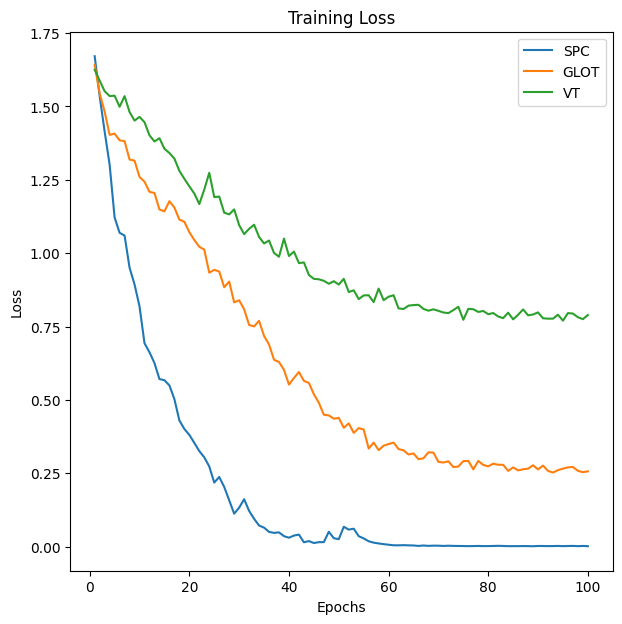

In [56]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['loss']
model_loss_glot = history_glot.history['loss']
model_loss_vt = history_vt.history['loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

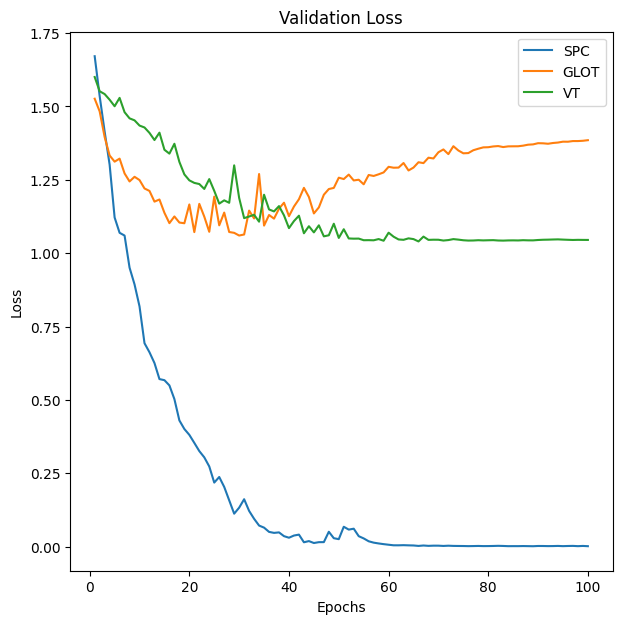

In [57]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['val_loss']
model_loss_glot = history_glot.history['val_loss']
model_loss_vt = history_vt.history['val_loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

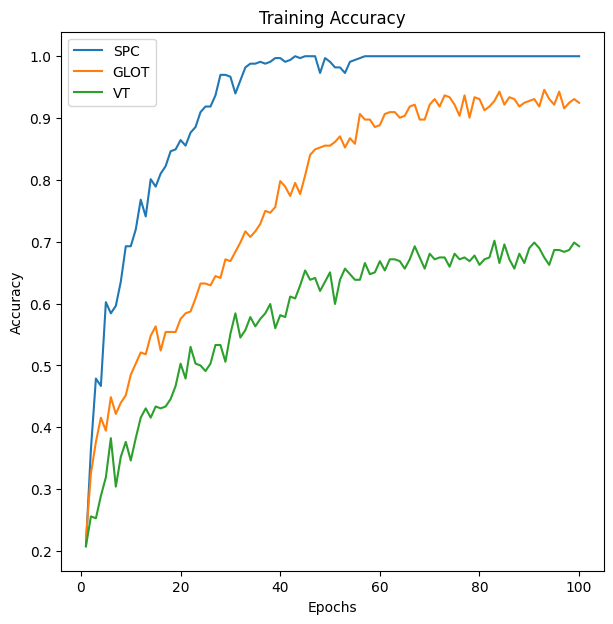

In [60]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['accuracy']
model_loss_glot = history_glot.history['accuracy']
model_loss_vt = history_vt.history['accuracy']
plt.plot(range(1,len(model_loss)+1), model_loss_spc)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

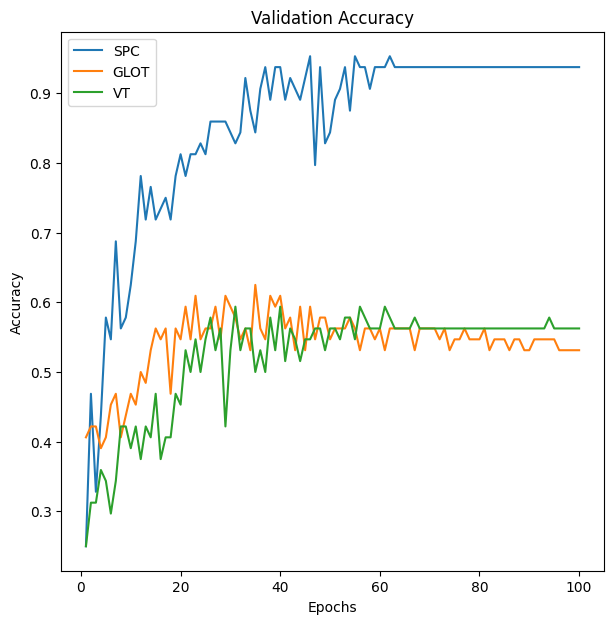

In [61]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['val_accuracy']
model_loss_glot = history_glot.history['val_accuracy']
model_loss_vt = history_vt.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_loss_spc)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

In [ ]:
globals().clear()

In [ ]:
locals().clear()